In [1]:
'''
Sunglint case study for paper
'''

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import glob
from contextlib import contextmanager
@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(newdir)
    try:
        yield
    finally:
        os.chdir(prevdir)


model_path = '/edata2/spencer/rfi_prediction/AMSR2/GCOMW1'

with cd(model_path):
    import local_functions
    import model_operations
    import sensor_info



In [39]:
flist = glob.glob(f'/pdata4/archive/GPM/1Base_AMSR2_V7/*/*/1Base.GCOMW1.AMSR2.*.HDF5'); flist.sort()

for ifile in flist:

    with xr.open_dataset(ifile, group='S1', decode_timedelta=False) as f:
        #lat = f.Latitude_6.values
        #lon = f.Longitude_6.values
        sgl_ang = f.Sun_Glint_Angle.values
        good = sgl_ang > 0.
        sgl_ang = sgl_ang[good]
        if np.any(sgl_ang) < 10:
            print(ifile, np.where(sgl_ang < 10)[0].shape)


/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120702/1Base.GCOMW1.AMSR2.TB2021.20120702-S223117-E001009.000676.V07A.HDF5 (0,)
/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120703/1Base.GCOMW1.AMSR2.TB2021.20120703-S001010-E014902.000677.V07A.HDF5 (6640,)
/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120703/1Base.GCOMW1.AMSR2.TB2021.20120703-S014903-E032755.000678.V07A.HDF5 (6635,)
/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120703/1Base.GCOMW1.AMSR2.TB2021.20120703-S032756-E050648.000679.V07A.HDF5 (6637,)
/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120703/1Base.GCOMW1.AMSR2.TB2021.20120703-S050649-E064541.000680.V07A.HDF5 (6635,)
/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120703/1Base.GCOMW1.AMSR2.TB2021.20120703-S064542-E082434.000681.V07A.HDF5 (6633,)
/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120703/1Base.GCOMW1.AMSR2.TB2021.20120703-S082435-E100327.000682.V07A.HDF5 (6637,)
/pdata4/archive/GPM/1Base_AMSR2_V7/1207/120703/1Base.GCOMW1.AMSR2.TB2021.20120703-S100328-E114219.000683.V07A.HDF5 (6635,)
/pdata4/archive/GPM

KeyboardInterrupt: 

In [2]:
file = '/pdata4/archive/GPM/1Base_AMSR2_V7/1209/120920/1Base.GCOMW1.AMSR2.TB2021.20120920-S205147-E223039.001840.V07A.HDF5'
with xr.open_dataset(file, group='S1') as f:
    lat = f.Latitude_6.values
    lon = f.Longitude_6.values
    sgl_ang = f.Sun_Glint_Angle.values
    qual = f.Pixel_Data_Quality_6_to_36.values

/tmp/ipykernel_919458/2193219487.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  with xr.open_dataset(file, group='S1') as f:


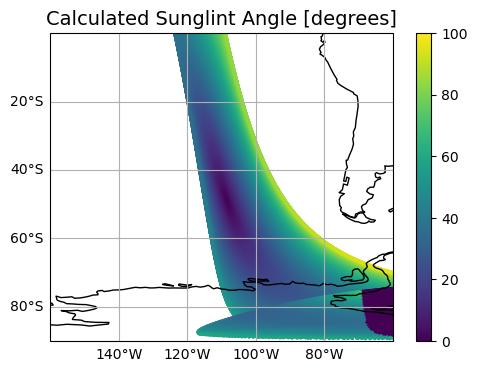

In [70]:
extent = [-160,-60,-90,0]

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(lon, lat, c=sgl_ang[:,:], transform=ccrs.PlateCarree(), s=2., vmin=0, vmax=100)
plt.colorbar(mappable=im, shrink=1)
plt.title('Calculated Sunglint Angle [degrees]', fontsize=14)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)
plt.show()

In [51]:
data = local_functions.read_amsr2_l1b(file)

/edata2/spencer/rfi_prediction/AMSR2/GCOMW1/local_functions.py:54: RuntimeWarning: invalid value encountered in cast
  qual[:,:,0] = f.Pixel_Data_Quality_6_to_36.values[:,::2]


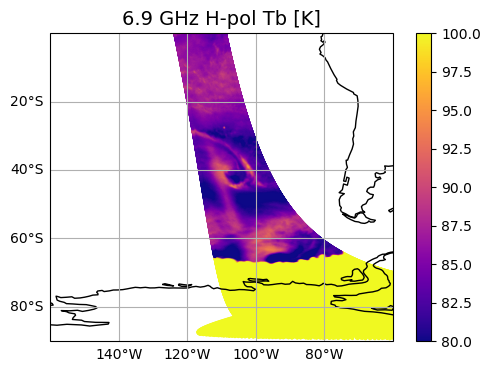

In [75]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=data['Tbs'][:,:,1], transform=ccrs.PlateCarree(), 
                s=2., vmin=80, vmax=100, cmap='plasma')
plt.colorbar(mappable=im, shrink=1.)
plt.title('6.9 GHz H-pol Tb [K]', fontsize=14)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)
plt.show()

In [54]:
def get_prediction_error(lat, lon, Tbs, scantime, modelpath, sensor):
    
    good = ~np.isnan(lat)

    nscans, npixs, nchans = Tbs.shape
    scantime = local_functions.copy_columns(scantime, npixs)

    with cd(modelpath):
        #Load in model tree
        model_tree = model_operations.load_model_tree()
        #Attach GPM surface type
        sfctype = np.zeros([nscans,npixs], dtype=np.int32)
        sfctype[:] = -99
        sfctype[good] = local_functions.attach_gpm_sfctype(lat[good], 
                                                           lon[good],
                                                           scantime[good], 
                                                           sensor=sensor)
        #Do Tb prediction
        Tbs_pred = np.zeros_like(Tbs)
        Tbs_pred[:] = np.nan
        Tbs_pred[good] = model_operations.run_predictions(Tbs[good], 
                                                          sfctype[good], 
                                                          model_tree, 
                                                          keep_dims=False)

        #Load in stats files
        mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
        std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
        mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
        std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)

    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    epsilon_hat[:] = np.nan

    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)

    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    
    return epsilon_hat

pred_err = get_prediction_error(
    data['lat'], data['lon'], data['Tbs'], data['scantime'],
    model_path, 'AMSR2'
)

In [78]:
error_threshold = 3
mlflag = np.zeros_like(data['Tbs'], dtype=np.int32)
mlflag[pred_err > error_threshold] = 1
mlflag[np.isnan(pred_err)] = -2

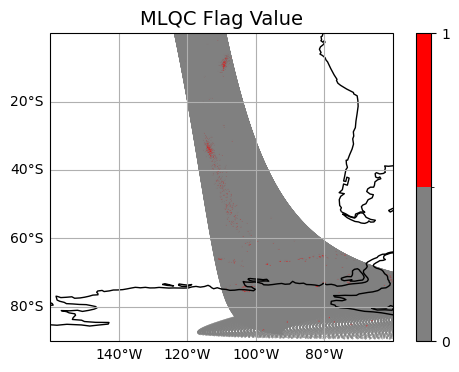

In [79]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(["gray", "red"])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=mlflag[:,:,1], 
                transform=ccrs.PlateCarree(), 
                s=0.1, cmap=cmap, norm=norm)
#plt.colorbar(mappable=im, shrink=0.5)
cbar = plt.colorbar(im, shrink=1., ticks=[0, 1])
cbar.ax.set_yticklabels(["0", "1"])
plt.title('MLQC Flag Value', fontsize=14)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)
plt.show()

In [7]:
file = '/pdata4/archive/GPM/1C_NOAA20_V7/2001/200116/1C.NOAA20.ATMS.XCAL2019-V.20200116-S023002-E041131.011191.V07A.HDF5'

with cd(model_path):
    data = local_functions.read_atms_l1c(file)



AttributeError: module 'local_functions' has no attribute 'read_atms_l1c'

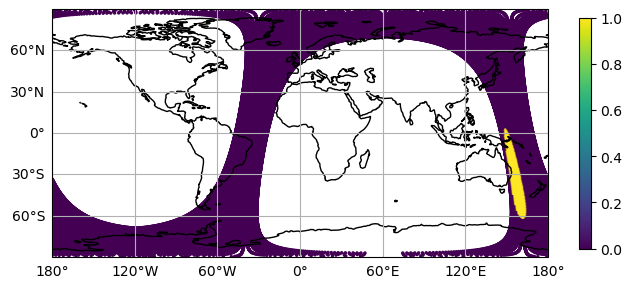

In [30]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=data['qual'][:,:,0], transform=ccrs.PlateCarree(), s=2.)
plt.colorbar(mappable=im, shrink=0.5)
plt.title('')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

In [31]:
with cd(model_path):
    mlflag = model_operations.ml_quality_control(file, error_threshold=4)
    nscans, npixs = data['lat'].shape
    mlflag = mlflag.reshape(nscans,npixs,-1)

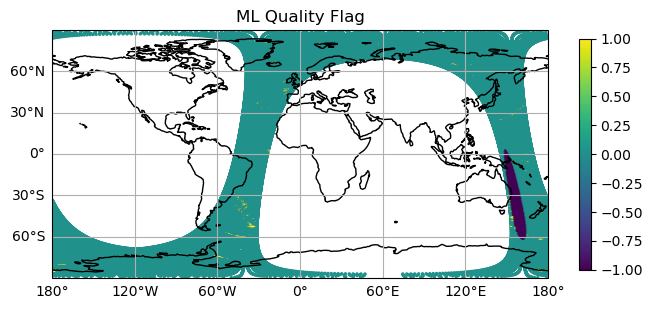

In [32]:
chan = ['24QV']

chan_desc = np.array(sensor_info.channel_descriptions)
chan_indx = np.where(chan == chan_desc)[0]

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=mlflag[:,:,chan_indx], transform=ccrs.PlateCarree(), s=2.)
plt.colorbar(mappable=im, shrink=0.5)
plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

In [33]:
'''
Now look at actual prediction error
'''

with cd(model_path):
    model_tree = model_operations.load_model_tree()
    sfctype = local_functions.attach_gpm_sfctype(data['lat'], data['lon'], data['scantime'], sensor='ATMS')
    Tbs_pred = model_operations.run_predictions(data['Tbs'], sfctype, data['scanpos'], model_tree)
    mean_ocn = {}
    std_ocn  = {}
    mean_non = {}
    std_non  = {}
    for i in range(48):
        mean_ocn[f'scanpos{i}'] = np.fromfile(f'eval_stats/mean_ocn_scanpos{i}.arr', sep='', dtype=np.float32)
        std_ocn[f'scanpos{i}']  = np.fromfile(f'eval_stats/std_ocn_scanpos{i}.arr', sep='', dtype=np.float32)
        mean_non[f'scanpos{i}'] = np.fromfile(f'eval_stats/mean_non_scanpos{i}.arr', sep='', dtype=np.float32)
        std_non[f'scanpos{i}']  = np.fromfile(f'eval_stats/std_non_scanpos{i}.arr', sep='', dtype=np.float32)


    

In [34]:
epsilon_hat = np.zeros_like(Tbs_pred)
epsilon        = np.zeros_like(Tbs_pred)
epsilon_hat[:] = np.nan
epsilon[:]     = np.nan
epsilon = data['Tbs'] - Tbs_pred
ocean = sfctype == 1
ocean = ocean.reshape(nscans,npixs)
nonocean = sfctype > 1
nonocean = nonocean.reshape(nscans,npixs)
for i in range(48):
    mean_o = mean_ocn[f'scanpos{i}']
    std_o  = std_ocn[f'scanpos{i}']
    mean_n = mean_non[f'scanpos{i}']
    std_n  = std_non[f'scanpos{i}']
    correct_scanpos = data['scanpos'] == i
    both_ocn = np.logical_and(correct_scanpos, ocean)
    both_non = np.logical_and(correct_scanpos, nonocean)
    epsilon_hat[both_ocn] = np.abs(epsilon[both_ocn] - mean_o) / std_o
    epsilon_hat[both_non] = np.abs(epsilon[both_non] - mean_n) / std_n

In [35]:
# error_threshold = 4
# mlflag = np.zeros(data['Tbs'].shape, dtype=np.int32)
# mlflag[epsilon_hat > error_threshold] = 1

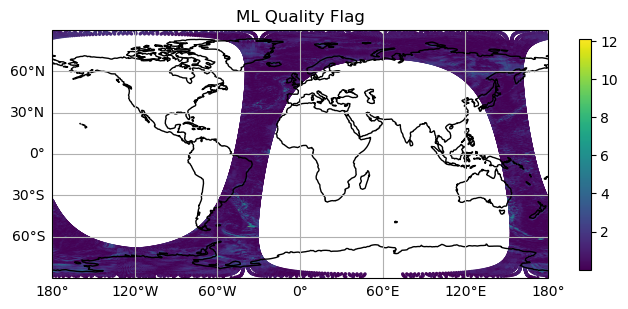

In [36]:
chan = ['24QV']

chan_desc = np.array(sensor_info.channel_descriptions)
chan_indx = np.where(chan == chan_desc)[0]

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=epsilon_hat[:,:,chan_indx], transform=ccrs.PlateCarree(), s=2.)
plt.colorbar(mappable=im, shrink=0.5)
plt.title('ML Quality Flag')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()